In [0]:
import os

In [0]:
os.chdir("/content/drive/My Drive/human_seg")

In [29]:
!git clone https://github.com/liruilong940607/OCHumanApi
os.chdir("OCHumanApi")
!make install
os.chdir("../")
os.listdir()

fatal: destination path 'OCHumanApi' already exists and is not an empty directory.
# install ochumanApi to the Python site-packages
python setup.py build_ext install
running build_ext
building 'ochumanApi._mask' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/ochumanApi
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -IochumanApi -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I./ -I/usr/include/python3.6m -c ochumanApi/_mask.c -o build/temp.linux-x86_64-3.6/ochumanApi/_mask.o -Wno-cpp -Wno-unused-function -std=c99
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -IochumanApi -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I./ -I/usr/include/python3.6m -c ochumanApi/maskApi.c -o build/temp.lin

['images.zip',
 'ochuman_coco_format_test_range_0.00_1.00.json',
 'ochuman_coco_format_val_range_0.00_1.00.json',
 'ochuman.json',
 'images',
 'OCHumanApi',
 'val',
 'test',
 'sample.png',
 'custom_dataset_human',
 'script.ipynb',
 'intermediate_results',
 'Training Segementaion Unet.h5',
 'training.ipynb',
 'img_create.ipynb']

In [0]:
from ochumanApi.ochuman import OCHuman
import cv2, os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15)

import ochumanApi.vis as vistool
from ochumanApi.ochuman import Poly2Mask

import cv2
from google.colab.patches import cv2_imshow
from tqdm.notebook import tqdm
import numpy as np

In [31]:
# <Filter>: 
#      None(default): load all. each has a bbox. some instances have keypoint and some have mask annotations.
#            images: 5081, instances: 13360
#     'kpt&segm' or 'segm&kpt': only load instances contained both keypoint and mask annotations (and bbox)
#            images: 4731, instances: 8110
#     'kpt|segm' or 'segm|kpt': load instances contained either keypoint or mask annotations (and bbox)
#            images: 5081, instances: 10375
#     'kpt' or 'segm': load instances contained particular kind of annotations (and bbox)
#            images: 5081/4731, instances: 10375/8110
ochuman = OCHuman(AnnoFile='ochuman.json', Filter='segm')
image_ids = ochuman.getImgIds()
print ('Total images: %d'%len(image_ids))

Total images: 4731


In [0]:
def get_segmentation(data):
    img = cv2.imread(os.path.join(ImgDir, data['file_name']))
    height, width = data['height'], data['width']

    colors = [[255, 0, 0], 
            [255, 255, 0],
            [0, 255, 0],
            [0, 255, 255], 
            [0, 0, 255], 
            [255, 0, 255]]


    for i, anno in enumerate(data['annotations']):
        bbox = anno['bbox']
        kpt = anno['keypoints']
        segm = anno['segms']
        max_iou = anno['max_iou']

        # img = vistool.draw_bbox(img, bbox, thickness=3, color=colors[i%len(colors)])
        if segm is not None:
            mask = Poly2Mask(segm)
            img = vistool.draw_mask(img, mask, thickness=3, color=colors[i%len(colors)])
        # if kpt is not None:
        #     img = vistool.draw_skeleton(img, kpt, connection=None, colors=colors[i%len(colors)], bbox=bbox)
    return img

In [0]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
ImgDir = 'images/'

In [0]:
def new_mask(real_img, m_img):
    real_img = real_img.reshape(1, -1)[0]
    m_img = m_img.reshape(1, -1)[0]

    new = []

    for i, j in zip(real_img, m_img):
        if i != j:
            new.append(255)
        else:
            new.append(0)

    new_np = np.array(new)
    new_np = new_np.reshape(512, 512, 3)

    return new_np

In [38]:
def generator_images(batch_size, ind):
    while True:
        x_batch = []
        y_batch = []

        for i in range(batch_size):
            data = ochuman.loadImgs(imgIds=[image_ids[ind]])[0]

            file_name = data['file_name']

            img = cv2.imread(ImgDir+'/'+file_name)
        
            y = get_segmentation(data)

            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            y = cv2.resize(y, (IMG_WIDTH, IMG_HEIGHT))
           
            
            new = new_mask(img, y)

            img = img / 255.
            y = new / 255.
            
            x_batch.append(img)
            y_batch.append(y)

        
        x_batch = np.array(x_batch)
      
        y_batch = {'seg': np.array(y_batch)
                    }

        yield x_batch, y_batch

for x, y in generator_images(2, 1):
    break

print(x.shape, y['seg'].shape)

(2, 512, 512, 3) (2, 512, 512, 3)


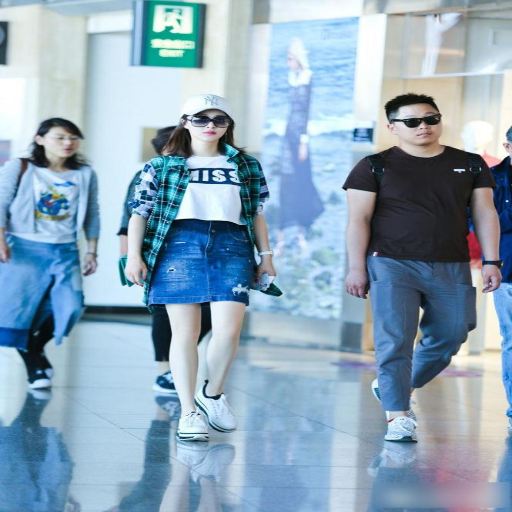

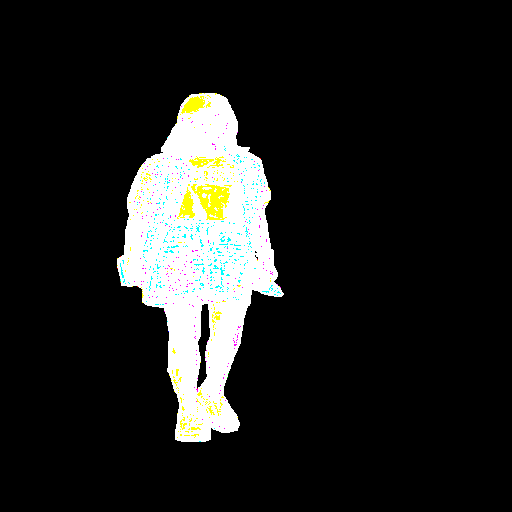

In [39]:
cv2_imshow(x[0] * 255.)
cv2_imshow(y['seg'][0] * 255.)

In [0]:
for i in tqdm(range(4731)):
    for x, y in generator_images(1, i):
        break

    base_dir_custom = "custom_dataset_human_black_background/"
    try:
        os.makedirs(f'{base_dir_custom}')
    except:
        pass
    try:
        os.makedirs(f'{base_dir_custom}features/')
    except:
        pass
    try:
        os.makedirs(f'{base_dir_custom}labels/')
    except:
        pass
        
    x_name = f"{base_dir_custom}features/{i}_x.jpg"
    y_name = f"{base_dir_custom}labels/{i}_y.jpg"
    cv2.imwrite(x_name, x[0] * 255.)
    cv2.imwrite(y_name, y['seg'][0] * 255.)

In [0]:
len(os.listdir(f"{base_dir_custom}features/"))

4731

In [0]:
len(os.listdir(f"{base_dir_custom}labels/"))

4731